# Detecting Fake News using NLP techniques

This project aims to constructs a machine learning model using Natural Language Inference (NLI) to detect whether a news article is considered fake or real based on a labled dataset.
Using the FakeNewsNet database, which contains scapped data from PoliticFact.Com (a reputable source of fact-finding in which a news team and fact-finding experts evaluate political news articles published in various sources (CNN, BBC, Facebook) [1]. The dataset has 15212 training samples, 1058 validation samples, and 1054 test samples wherein the classes of this data are “real” and “fake”.

**The Dataset columns:**

* **id**: matches the id in the PolitiFact website API (unique for each sample)

* **date**: The time each article was published in the PolitiFact website

* **speaker**: The person or organization to whom the Statement relates

* **statement**: A claim published in the media by a person or an organization and has been investigated in the PolitiFact article.

* **sources**: The sources used to analyze each Statement

* **paragraph_based_content**: content stored as paragraphed in a list

* **fullText_based_content**: Full text using pasted paragraph

* **label**: The class for each sample


### Important:
The project uses Google's BERT for pre-processing and then converted to TensorFlow 2.0+ for inputting into the model.
Hence the following package **must be installed:**

In [1]:
"""

!pip install bert-for-tf2 
!pip install sentencepiece

try: %tensorflow_version 2.x 
except Exception: 
pass 

"""

'\n\n!pip install bert-for-tf2 \n!pip install sentencepiece\n\ntry: %tensorflow_version 2.x \nexcept Exception: \npass \n\n'

In [2]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
import re 
import nltk 
nltk.download('stopwords') 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import math
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
import tensorflow  as tf 
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from bert.tokenization.bert_tokenization import FullTokenizer
import bert
import random
from sklearn.preprocessing import LabelEncoder
tf.executing_eagerly()
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VIGS2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading the data

In [3]:
df = pd.read_csv('fnn_train.csv')

Given that we want to predict fake news, we take Fake news lables as the positive class

In [4]:
# changing label from real/fake to 0 & 1:
# Fake = 1 ; Real = 0

df['label_fnn'] = df['label_fnn'].replace('fake',1)
df['label_fnn'] = df['label_fnn'].replace('real',0)
df.head()

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,1
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,1
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,Says the Southwest Florida Water Management Di...,['http://www.tampabay.com/news/politics/gubern...,"[""Here's a new one: The Senate budget committe...",Here's a new one: The Senate budget committee ...,1
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,"""The Congressional Budget Office has this econ...",['http://www.cnn.com/2011/POLITICS/03/17/gop.b...,"['Recently, House Budget chairman Paul Ryan, R...","Recently, House Budget chairman Paul Ryan, R-W...",0
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,"Says the Treasury Department ""says 41 percent ...",['http://frelinghuysen.house.gov/index.cfm?sec...,['The millionaires’ tax proposal made its late...,The millionaires’ tax proposal made its latest...,1


### Exploratory Data Analysis

**Most fake news per individual/organization**

In [5]:
# grouping speakers and counting how many fake lables they each have:

df.groupby('speaker').sum().sort_values(by=['label_fnn'],ascending=False).head(10)

,id,label_fnn
speaker,,
Donald Trump,10184611,520
Facebook posts,8310156,450
Viral image,5530797,311
Bloggers,4609210,278
Chain email,727574,153
Barack Obama,2280594,138
Scott Walker,1704676,89
Ted Cruz,1417640,85
Mitt Romney,818663,82


In [6]:
# For further EDA created a sub dataset of all the speakers and how many news items each have:
EDA_df = pd.DataFrame()
EDA_df = df.groupby('speaker').count().reset_index()[['speaker','label_fnn']]
EDA_df.columns = ['Person/Organization', 'Total number of news statements recorded']

# Adding columns to the new EDA_df; Count of News articles, number Fkae News and percentage of Fakeness (Fake news vs Total news):
EDA_df['Number of Fake news statements'] = df.groupby('speaker').sum().reset_index()['label_fnn']
EDA_df['Percentage of Fake news statements']= (EDA_df['Number of Fake news statements']/EDA_df['Total number of news statements recorded'])*100
EDA_df.sort_values(by=['Percentage of Fake news statements'],ascending=False)

#Selecting News contributors that published atleat 10 contributions of news
filter_10 = (EDA_df['Total number of news statements recorded']>=10)
EDA_df=EDA_df[filter_10].reset_index().drop('index',axis =1)

**Top contributors of Fake news**

[Text(0, 0, 'Donald Trump'),
 Text(0, 0, 'Facebook posts'),
 Text(0, 0, 'Viral image'),
 Text(0, 0, 'Bloggers'),
 Text(0, 0, 'Chain email')]

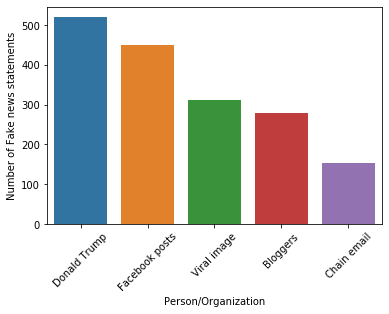

In [7]:
# Determining the people/organization that have more than 70% of their news as Fake news
filter_fake = (EDA_df['Percentage of Fake news statements'] >= 70)
Top_fake = EDA_df[filter_fake].reset_index().drop('index',axis=1)
Top_fake.sort_values(by=['Number of Fake news statements'],ascending=False,inplace=True)

# Top 5 contributors of Fake News
sns.barplot(data=Top_fake[:5], x=Top_fake['Person/Organization'][:5],
            y=Top_fake['Number of Fake news statements'][:5]).set_xticklabels(Top_fake['Person/Organization'][:5],rotation=45)

**Fake Statments made**

The top  words that were used in a Fake news statement

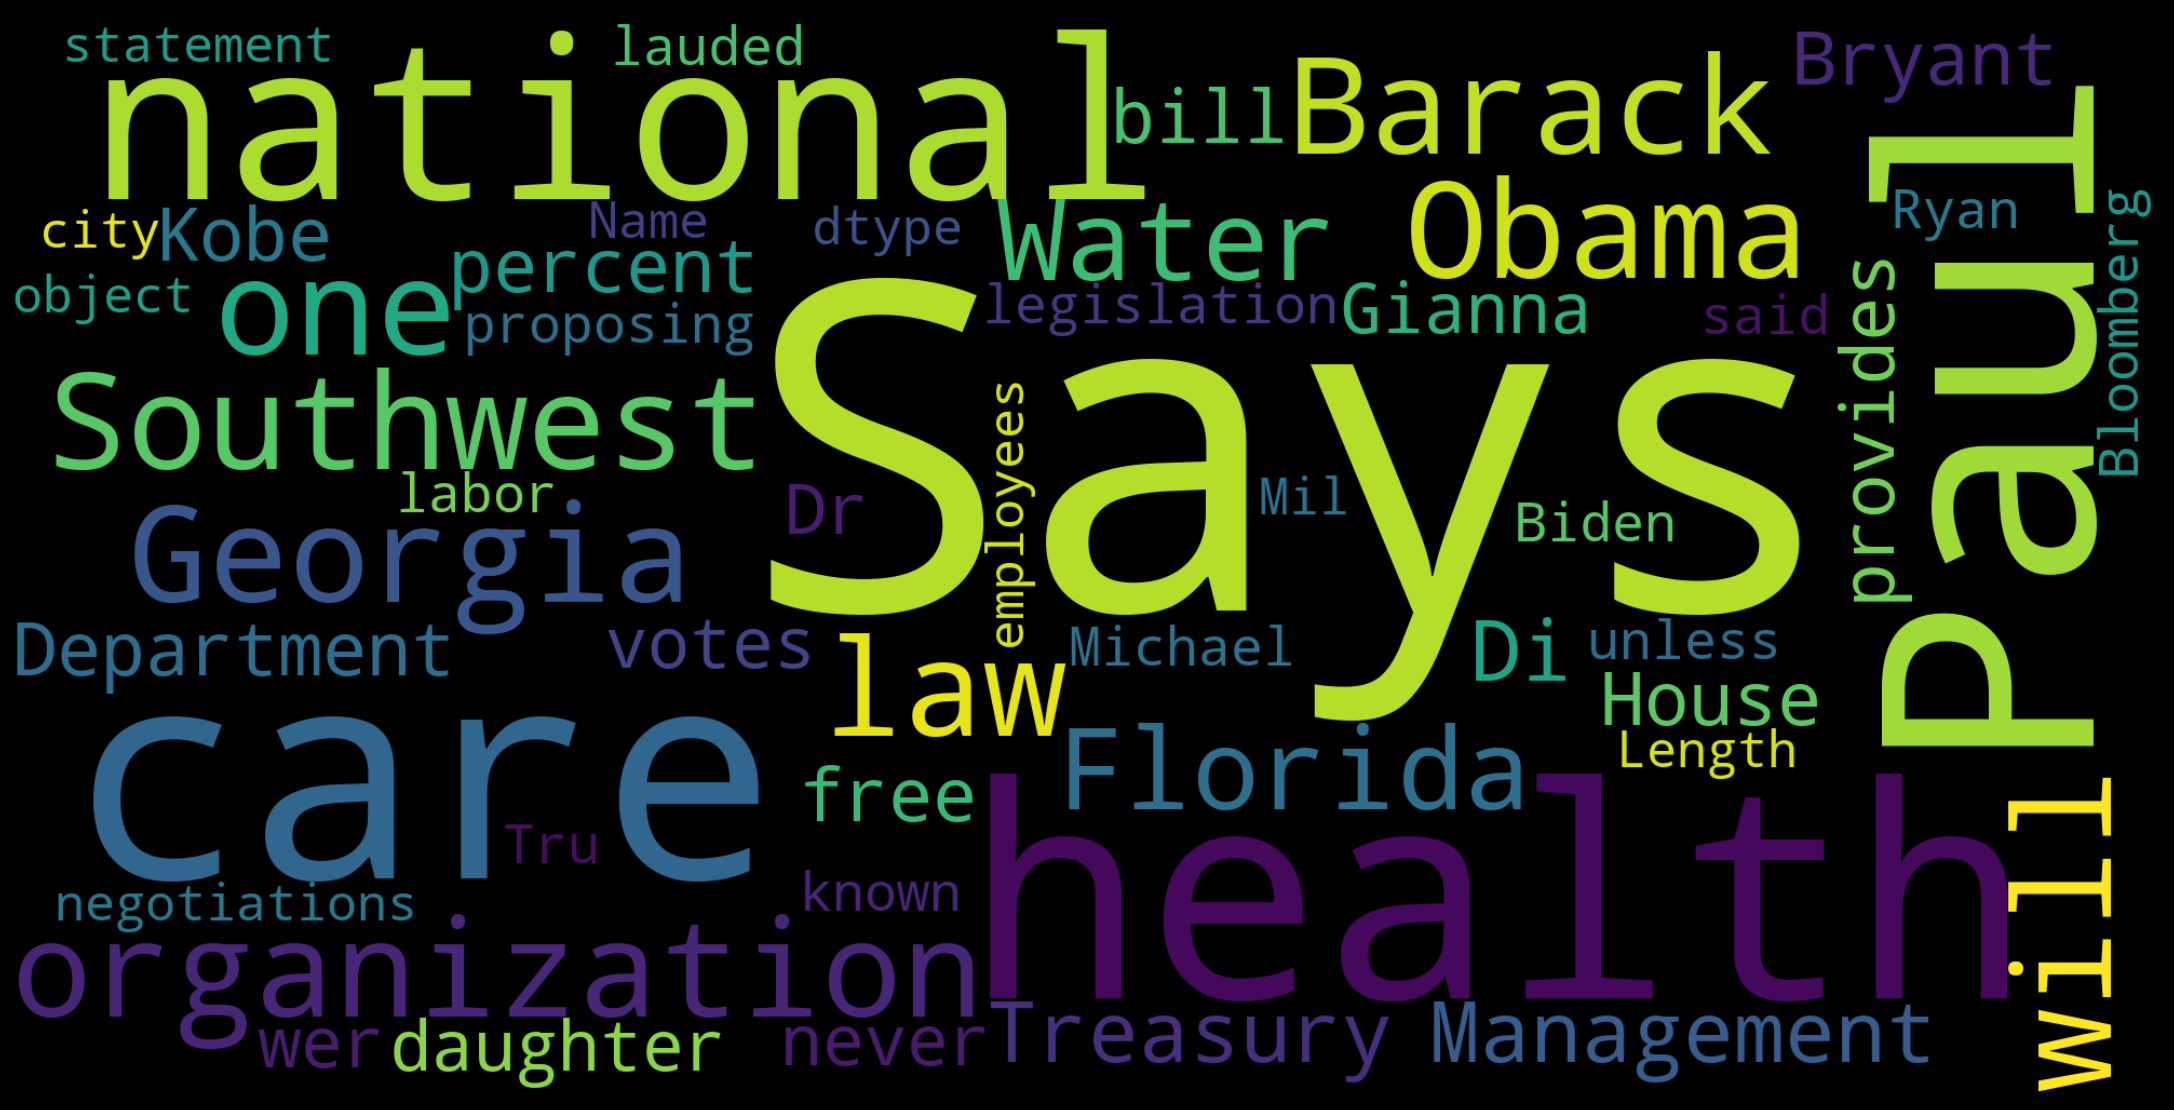

In [39]:
# World cloud on the various statements that were labelled as Fake news
df_fake = df.loc[df['label_fnn'] == 1]
text = df_fake['statement']
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Fake News statements')
plt.tight_layout(pad=0)
plt.show()

# Pre-processing for the Base model

For building the base model, we first need to process the text data using the NLP technique of constructing a 'Corpus' of processed words from each news article. The corpus of individual words split from their sentences, then need to encode this text data by the process of vectorization called TfidfVectorizer (Term Frequency – Inverse Document) [2]. Here the method calculates the frequency of each word i.e., most frequent in an article. 

**Building the word corpus**

In [9]:
df1=df[['fullText_based_content','label_fnn']]

In [10]:
# Creating Corpus
corpus = [] # Build a new list for all the words from texts
for i in range (0, df1.shape[0]):
    text = re.sub('[^a-zA-Z]', ' ', df1['fullText_based_content'][i] )# all characters that are alphabets to be selected
    text = text.lower()# lower cases each word, uniformity
    text = text.split() # splits each word from its sentence
    ps =PorterStemmer()
    text = [ps.stem(word) for word in text if not  word in set(stopwords.words('english'))]#Cuts each word to its root meaning
    text = ' '.join(text)
    corpus.append(text)

**Vectorization using TFIDf**

In [12]:
# TF-IDF model
# Vectorizes the top 4500 frequent words:
vectorizer = TfidfVectorizer (max_features=4500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))

#Spliting the dataset's target values from its features:
X = vectorizer.fit_transform(corpus).toarray()
y = df1.iloc[:, 1].values

**With this pre-processing done, the next step is creating a baseline model**

# Base Model

**Summary of Baseline model**
* Used an ensemble of learning algorithms to determine best classifier.
* Random Forest classifier achieved the best test accuracy score of -69%

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [14]:
# Modelling using TF-IDF model

log_reg= LogisticRegression(solver='liblinear')

lsvm_clf=LinearSVC(loss='hinge',random_state=100)

svm_clf=SVC()

neighbors_clf=KNeighborsClassifier()

random_forest=RandomForestClassifier(criterion= 'entropy', max_depth= 70, n_estimators= 150)

deci_tree_clf=DecisionTreeClassifier()

NB_clf = GaussianNB()

for clf in (log_reg,lsvm_clf,svm_clf,neighbors_clf,deci_tree_clf,random_forest,NB_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print('Performance metrics for ',clf.__class__.__name__,' :- ')
    print('Accuracy score ', accuracy_score(y_test,y_pred))
    print('Precision', precision_score(y_test, y_pred))
    print('Recall', recall_score(y_test, y_pred))
    print('f1', f1_score(y_test, y_pred))
    print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))
    print("------------------------------------------------------------\n------------------------------------------------------------\n")



Performance metrics for  LogisticRegression  :- 
Accuracy score  0.6825501150180743
Precision 0.7115666178623719
Recall 0.6295336787564767
f1 0.668041237113402
Confusion Matrix: 
 [[1105  394]
 [ 572  972]]
------------------------------------------------------------
------------------------------------------------------------

Performance metrics for  LinearSVC  :- 
Accuracy score  0.6776207689779823
Precision 0.7083641746854182
Recall 0.6198186528497409
f1 0.661139896373057
Confusion Matrix: 
 [[1105  394]
 [ 587  957]]
------------------------------------------------------------
------------------------------------------------------------

Performance metrics for  SVC  :- 
Accuracy score  0.6789352612553401
Precision 0.7136397889977393
Recall 0.6133419689119171
f1 0.6597004528039011
Confusion Matrix: 
 [[1119  380]
 [ 597  947]]
------------------------------------------------------------
------------------------------------------------------------

Performance metrics for  KNeighbo

Vectorization is not a very strong technique to process text data, as it lacks to bring meaningful context of the words into its processes.
Hence we use a more robust NLP technique called BERT

# Pre-processing for the improved Model using BERT

Using Google's open-sourced new technique for Natural Language Processing called BERT (Bidirectional Encoder Representations from Transformers), we improved the prediction by firstly using BERT to encode the text data into a meaninful format, with which we then can build an improved model [3]

**Loading the dataset**

In [15]:
train_df = pd.read_csv('fnn_train.csv') #Train data
test_df = pd.read_csv('fnn_test.csv') #Test Data
dev_df = pd.read_csv('fnn_dev.csv') # Validation data

# Given the ratio of test to train data does not cross even a 10% split, hence we combined the validation and test data enlarge the dataset:
test_df = pd.DataFrame(np.concatenate([test_df.values, dev_df.values]), columns=test_df.columns)
test_df.shape

(2112, 8)

**Pre-processing Text**

In [16]:
# Function to preprocess the text data
def preprocess_text(sen):
    
    sentence = remove_tags(sen)# Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)# Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)# Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [17]:
# Appending the processed text and splitting the target values
train_statement = []
sentences = list(train_df['fullText_based_content'])
for sen in sentences:
    train_statement.append(preprocess_text(sen))
    
y_train = train_df['label_fnn']
y_train = np.array(list(map(lambda x: 1 if x=="fake" else 0, y_train))) # positive class here is 'Fake news'    

**Using BERT's Tokenizer**
Here BERT tokenizes words by masking each word in a sentence and then converting these tokens into a context-based representation for further ML processing. Using the uncased tokenizer from BERT.

In [18]:

# Tokenizer -dividing a sentence into individual words that have relative context to each other
BertTokenizer = bert.bert_tokenization.FullTokenizer # creating an object that tokenizes using BERT
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False) # embedding layer- converts words into numercial data that have context tothe word
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()# vocabulary array - contains all the words
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()# lower case the words
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)# pass the 2 into the tokenizer

In [19]:
# creating a function that gets the Index ids of each token (word)
def tokenize_words(statements_text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(statements_text))

# Indexing the tokens to the words
tokenized_statements = [tokenize_words(train_statement) for train_statement in train_statement]

**The tokenized_statements have taken each one of the words and convereted them to numerals such as:**

In [47]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize('Obama put a 10 percent tax on tanning'))

[8112, 2404, 1037, 2184, 3867, 4171, 2006, 9092, 5582]

 
The difference from vectorization is that tokenization can assign a token to a word or a set of words (phrase, sentence) that could be found mulitple times in the corpus.

**Prerparing Data For Training**

As each news article (samples) are of varying lengths, upon Tokenization the array of words tokenized in each sample will be unequal amongst others. Hence to create arrays of equal lengths the smallest sample is padded with 0 based on the largest sentences’ length. We do this in batches rather than the whole dataset the latter would lead to a sparse matrix (i.e., a matrix with few non-zero elements)

In [49]:
# Length of each news article
statements_with_len = [[train_statement, y_train[i], len(train_statement)]
                 for i, train_statement in enumerate(tokenized_statements)]

# shuffling the order to avoid having same target values consecutively:
random.shuffle(statements_with_len)

statements_with_len.sort(key=lambda x: x[2])# sorting based on length of article

sorted_statement_labels = [(statement_label[0], statement_label[1]) for statement_label in statements_with_len]

# With this sorted data, converting to be used with TensorFlow:
processed_train_dataset = tf.data.Dataset.from_generator(lambda: sorted_statement_labels, output_types=(tf.int32, tf.int32))

# Padding the dataset for each batch; after processing 32 articles, the weights of the ML model will be updated.
BATCH_SIZE = 32
batched_train_dataset = processed_train_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

**Padding is being applied as the features need to be the same length in tensor flow.**

The model will first look for the max tokenization string and will establish that as the maximum length, all other rows that are not as long as the max will receive as many zeros as it takes to make it equal to the greatest length.
This is an example of a array that is padded:

In [53]:
next(iter(batched_train_dataset))

(<tf.Tensor: shape=(32, 189), dtype=int32, numpy=
 array([[ 2829,  5963,  2003, ...,     0,     0,     0],
        [ 1996,  2193,  2089, ...,     0,     0,     0],
        [ 5971, 11372,  2031, ...,     0,     0,     0],
        ...,
        [ 1037,  2466, 22458, ...,     0,     0,     0],
        [ 2012,  1996, 17419, ...,     0,     0,     0],
        [ 2748,  2009,  2995, ...,  1997,  6701, 11357]])>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 1])>)

**Train-Validation split**

In [22]:
# Creating separate Validation set from the training data. 10% of the data is set for validation

TOTAL_BATCHES = math.ceil(len(sorted_statement_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_train_dataset.shuffle(TOTAL_BATCHES)
val_data = batched_train_dataset.take(TEST_BATCHES)
train_data = batched_train_dataset.skip(TEST_BATCHES)


**Preparing Test Data**

In [23]:
test_statement = []
sentences = list(test_df['fullText_based_content'])
for sen in sentences:
    test_statement.append(preprocess_text(sen))
    
y_test = test_df['label_fnn']
y_test = np.array(list(map(lambda x: 1 if x=="fake" else 0, y_test)))    

tokenized_statements = [tokenize_words(test_statement) for test_statement in test_statement]

statements_with_len = [[test_statement, y_test[i], len(test_statement)]
                 for i, test_statement in enumerate(tokenized_statements)]

random.shuffle(statements_with_len)
statements_with_len.sort(key=lambda x: x[2])

sorted_statement_labels = [(statement_label[0], statement_label[1]) for statement_label in statements_with_len]

processed_test_dataset = tf.data.Dataset.from_generator(lambda: sorted_statement_labels, output_types=(tf.int32, tf.int32))

BATCH_SIZE = 32
batched_test_dataset = processed_test_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))


# Improved Model-CNN

**Summary of Improved Model**
* Using data that was embedded using BERT Tokenizer, a CNN model was used to train the data
* A 1D CNN model, with 4 blocks of layers with pooling after each layer, finally converging on a FCNN
* Increase in model complexity led to improvement in the model

In [24]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer4 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=5,
                                        padding="valid",
                                        activation="relu")
                                        
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    # Sequence of events for the NN:
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3)
        l_4 = self.cnn_layer4(l)
        l_4 = self.pool(l_4)
        
        concatenated = tf.concat([l_1, l_2,l_3,l_4], axis=-1)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

**Hyperparameters chosen**

In [25]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.8

NB_EPOCHS = 7

**Calling the model with the chosen hyperparameters**

In [26]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])

**Instantiate the model**

In [27]:
history=text_model.fit(train_data, epochs=NB_EPOCHS,validation_data=val_data )

Epoch 1/7
19/19 [==============================] - 15s 791ms/step - loss: 0.7008 - accuracy: 0.5576 - val_loss: 0.6848 - val_accuracy: 0.5492
Epoch 2/7
19/19 [==============================] - 14s 761ms/step - loss: 0.6651 - accuracy: 0.6053 - val_loss: 0.6790 - val_accuracy: 0.5492
Epoch 3/7
19/19 [==============================] - 15s 769ms/step - loss: 0.6529 - accuracy: 0.6020 - val_loss: 0.6742 - val_accuracy: 0.5492
Epoch 4/7
19/19 [==============================] - 15s 765ms/step - loss: 0.5935 - accuracy: 0.7072 - val_loss: 0.6554 - val_accuracy: 0.5499
Epoch 5/7
19/19 [==============================] - 15s 770ms/step - loss: 0.5169 - accuracy: 0.7911 - val_loss: 0.6237 - val_accuracy: 0.7347
Epoch 6/7
19/19 [==============================] - 14s 762ms/step - loss: 0.3744 - accuracy: 0.9128 - val_loss: 0.5809 - val_accuracy: 0.8118
Epoch 7/7
19/19 [==============================] - 16s 835ms/step - loss: 0.2126 - accuracy: 0.9836 - val_loss: 0.5357 - val_accuracy: 0.8098


**Plotting the accuracies and losses**

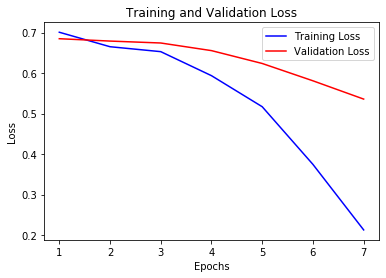

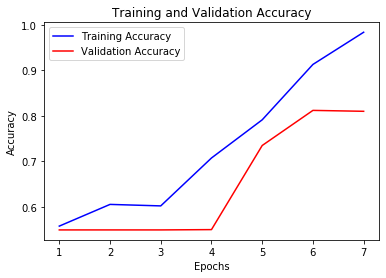

In [28]:

history_dict = history.history # the dictionary that has the information on loss and accuracy per epoch

loss_values = history_dict['loss']   # training loss
val_loss_values = history_dict['val_loss'] # validation loss

epochs = range(1, len(loss_values)+1)  #creates list of integers to match the number of epochs of training

# code to plot the results
plt.plot(epochs, loss_values, 'b', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.legend()
plt.show()

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Test Accuracy**

In [29]:
results = text_model.evaluate(batched_test_dataset)
print(results)

66/66 [==============================] - 8s 114ms/step - loss: 0.4104 - accuracy: 0.8646
[0.41036781668663025, 0.8645833134651184]


**Based on these results, we can see that the improved model could detect whether a news article is Fake or real with an 86% accuracy**

---

### References:

* [1] - https://ieee-dataport.org/open-access/fnid-fake-news-inference-dataset#files
* [2] - https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
* [3] - https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/

---